# ⚽S4E1 - EDA & initial submission - Binary Classification with a Bank Churn Dataset 

Welcome to 2024! For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

## Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## Submission Format

For each id in the test set, you must predict the probability for the target variable Exited. The file should contain a header and have the following format:

```
id,Exited
0,0.9
1,0.1
2,0.5
etc.
```

## Data Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. 

# Code

## ToC

- [Imports](#Imports)


## Imports

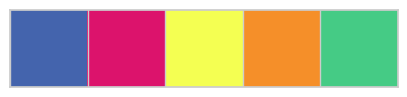

In [244]:
# essentials
import os
import pathlib
from copy import copy


import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, TweedieRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# others
import xgboost as xgb 
import lightgbm as lgb

import shap

RANDOM_SEED = 64

palette = ["#4464ad", "#dc136c", "#F4FF52", "#f58f29","#45cb85"]

sns.set_theme(style="whitegrid")
sns.set_palette(palette)
sns.palplot(palette)

## Data loading & EDA

First we will check

1. Number and types of columns
2. Number of rows in train and test
2. Missing values
3. Target variable distribution

In [245]:
IN_KAGGLE = False

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
input_folder = kaggle_folder if IN_KAGGLE else local_folder
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")

target_col = "Exited"

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    return df

train_df = initial_feature_engineering(train_df)

train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,True,False,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,True,True,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,True,False,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,True,True,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,True,True,15068.83,0


In [246]:
num_columns = len(train_df.columns)
num_rows = len(train_df)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  bool   
 10  IsActiveMember   165034 non-null  bool   
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: bool(2), float64(3), int64(5), object(3)
memory usage: 15.4+ MB


<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>Data shape</h4>
        <p>Data contains 13 columns, of which 8 are numeric, 2 are boolean and 3 are categorical. There are no missing values.</p>
    </div>
</div>

### Comparison of target column value counts across train and original datasets

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.despine()

fig.suptitle("Target distribution", fontsize=20)

sns.countplot(x=target_col, data=train_df, hue=target_col, ax=ax[0])
sns.countplot(x=target_col, data=original_df, hue=target_col, ax=ax[1])

plt.show()

KeyboardInterrupt: 

In [ ]:

total_train = len(train_df)
total_original = len(original_df)


train_target_pct = train_df[target_col].value_counts() / total_train
original_target_pct = original_df[target_col].value_counts() / total_original


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

sns.despine()

fig.suptitle("Target distribution (%)", fontsize=20)

sns.barplot(x=train_target_pct.index, y=train_target_pct.values, ax=ax[0], hue=train_target_pct.values, palette=palette, legend=False)
sns.barplot(x=original_target_pct.index, y=original_target_pct.values, ax=ax[1], hue=original_target_pct.values, palette=palette, legend=False)
plt.show()

In [ ]:
train_df[target_col].value_counts()

The competition dataset and original have similar target distribution - around 80% of customers stay with the bank in each.


Next steps:

4. Distribution of numeric features
5. Distribution of categorical features
6. Correlation between numeric features and target
7. Chi-square test on categorical features and target

## Distribution of numeric features

In [ ]:
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
# remove target col from list
numeric_features.remove(target_col)
print(numeric_features)

#### CustomerId - 'unique' identifier?

In [ ]:
train_df['CustomerId'].value_counts()

In [ ]:
val_cnt = train_df['CustomerId'].value_counts().reset_index()
val_cnt[ val_cnt['count'] > 1 ]

#### CreditScore


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()

fig.suptitle(f"CreditScore histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="CreditScore", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="CreditScore", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>Credit score</h4>
        <p>
          <ul>
            <li>Distribution has slight left skew, and we see the 850 cutoff as it's the max FICO credit score.</li>
            <li>Min value is 350, max is 850, 50% of customers have score of at least 659. FICO scores could be as low as 300, but we don't have such customers in the dataset.</li>
            <li>Credit score is not very different between customers who stay and leave</li>
          </ul>        
        </p>
    </div>
</div>

#### Age

In [ ]:
train_df['Age'].describe()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Age histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="Age", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="Age", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

Min Age is 18 while the oldest customer is 92 years old.

#### Tenure

In [ ]:
train_df['Tenure'].describe()

In [ ]:
train_df['Tenure'].value_counts()

In [ ]:
customers_less_than_1_yr = train_df[train_df['Tenure'] < 1]['CustomerId'].unique()
customers_more_than_9_yrs = train_df[train_df['Tenure'] > 9]['CustomerId'].unique()
total_cust = len(train_df)
print(f"Customers with less than 1 year of tenure: {len(customers_less_than_1_yr)/total_cust*100:.2f}%")
print(f"Customers with more than 9 years of tenure: {len(customers_more_than_9_yrs)/total_cust*100:.2f}%")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Tenure histogram", fontsize=20)

sns.histplot(x="Tenure", data=train_df, ax=ax, kde=True, color=palette[0])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Tenure histogram", fontsize=20)

sns.histplot(x="Tenure", data=train_df, ax=ax, kde=True, hue=target_col, color=palette[0])

Around 2% of customers have been with the bank for more than 9 years. Around the same number of customers came to bank less than 1 year ago.

#### Balance

In [ ]:
train_df['Balance'].describe()

In [ ]:
train_df[train_df[target_col] == 0]['Balance'].describe()

In [ ]:
train_df[train_df[target_col] == 1]['Balance'].describe()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Balance histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)
# distribution plot 

sns.histplot(x="Balance", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="Balance", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

sns.displot(train_df, x="Balance", hue=target_col, kind="ecdf")

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>Balance</h4>
        <p>
          <ul>
            <li>More than 50% of customers balance was 0 (at the time of data collection). Max balance is around 250k.</li>
            <li>Among customers who exited the bank, 50% of them had a balance of at least ~100k</li>
          </ul>        
        </p>
    </div>
</div>

#### NumOfProducts

In [ ]:
train_df['NumOfProducts'].describe()

In [ ]:
train_df[train_df[target_col] == 0]['NumOfProducts'].describe()

In [ ]:
train_df[train_df[target_col] == 0]['NumOfProducts'].describe()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"NumOfProducts histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="NumOfProducts", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="NumOfProducts", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"NumOfProducts histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="NumOfProducts", data=train_df, ax=ax, kde=True, hue=target_col, color=palette[0])

In [ ]:
three_or_more_products = train_df[train_df['NumOfProducts'] >= 3]
total_num_three_or_more_products = len(three_or_more_products)
val_cnt = three_or_more_products[target_col].value_counts()
# calculate pct
val_cnt = val_cnt / total_num_three_or_more_products * 100
val_cnt

In [ ]:
less_than_three = train_df[train_df['NumOfProducts'] < 3]
less_than_three[target_col].value_counts()

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>NumOfProducts</h4>
        <p>
          <ul>
            <li>In both groups, min number of products was 1 while max was 4</li>
            <li>Among customers who stay with bank, most of them have 2 products, while having 1 product is the second most common</li>
            <li>Among customers who exited the bank, having 1 product is the most common, but having 3 or 4 products is much more common than in the other group</li>
            <li>Almost 90% of customers who have 3 or 4 products leave the bank</li>
          </ul>        
        </p>
    </div>
</div>

#### EstimatedSalary

In [ ]:
train_df["EstimatedSalary"].describe()

In [ ]:
train_df[train_df[target_col] == 0]["EstimatedSalary"].describe()

In [ ]:
train_df[train_df[target_col] == 1]["EstimatedSalary"].describe()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.despine()
fig.suptitle(f"EstimatedSalary histogram ({target_col} = 0, {target_col} = 1) ", fontsize=20)

sns.histplot(x="EstimatedSalary", data=train_df[train_df[target_col] == 0], ax=ax[0], kde=True, color=palette[0])
sns.histplot(x="EstimatedSalary", data=train_df[train_df[target_col] == 1], ax=ax[1], kde=True, color=palette[1])

People who leave the bank have a slightly higher salary than those who stay.

## Categorical features

In [ ]:
categorical_features = train_df.select_dtypes(exclude=np.number).columns.tolist()

print(categorical_features)

#### HasCrCard

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"HasCrCard distribution between target groups", fontsize=20)

val_cnt = train_df[[target_col, 'HasCrCard']].value_counts(normalize=True).reset_index()
pivot_table = val_cnt.pivot_table(index='HasCrCard', columns=target_col, values='proportion', aggfunc=sum, fill_value=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"HasCrCard distribution between target groups", fontsize=20)

val_cnt = train_df[[target_col, 'HasCrCard']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='HasCrCard', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

#### IsActiveMember

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"IsActiveMember distribution between target groups", fontsize=20)

val_cnt = train_df[[target_col, 'IsActiveMember']].value_counts(normalize=True).reset_index()
pivot_table = val_cnt.pivot_table(index='IsActiveMember', columns=target_col, values='proportion', aggfunc=sum, fill_value=0)

sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"IsActiveMember distribution between target groups (proportions among target groups)", fontsize=20)

val_cnt = train_df[[target_col, 'IsActiveMember']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='IsActiveMember', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

<div>
    <div style="background-color: #4F8EC9; padding: 10px; border-radius: 5px; border: 5px solid #3C6D9C; margin: 10px 0;">
        <h4>HasCrCard & IsActiveMember</h4>
        <p>
          <ul>
            <li>Having a credit card does not seem to contribute to staying or leaving.</li>
            <li>70% of people who left were not active members while only 55% of people who stayed were active members.</li>
          </ul>        
        </p>
    </div>
</div>

#### Gender

In [ ]:
train_df[[target_col, 'Gender']].value_counts()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Gender proportions among target groups", fontsize=20)

val_cnt = train_df[[target_col, 'Gender']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='Gender', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

Among people who stay with bank, 60% are men, while 60% of people who leave the bank are women.

#### Geography

In [ ]:
train_df['Geography'].value_counts()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.despine()
fig.suptitle(f"Geography proportions among target groups", fontsize=20)

val_cnt = train_df[[target_col, 'Geography']].value_counts().reset_index()
pivot_table = val_cnt.pivot_table(index='Geography', columns=target_col, values='count', aggfunc=sum, fill_value=0)
# divide each cell by total sum in each column
pivot_table = pivot_table / pivot_table.sum(axis=0)
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="Reds")
val_cnt

#### Surname

In [ ]:
train_df['Surname'].value_counts()

Not likely to be useful for prediction. We will drop this column before training.

## Correlation between numeric features and target

In [ ]:
# plot correlation matrix

corr_matrix = train_df[numeric_features + [target_col]].corr( method='pearson')


fig.suptitle("Correlation matrix", fontsize=20)

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Reds")

There are not corellated features

## Chi-square test on categorical features and target

Here we want to create a table which could tell us by which features the target groups differ the most. We will use chi-square test to check if the difference is statistically significant.

In [ ]:
from scipy.stats import chi2_contingency

def chi_square_test(dataframe, target_col, categorical_features):
    # Create a dictionary to hold the results
    results = {"Feature": [], "Chi-Square Statistic": [], "p-Value": [], "Significant": []}

    # Split the data into two groups based on the target column
    group_1 = dataframe[dataframe[target_col] == 0]
    group_2 = dataframe[dataframe[target_col] == 1]

    # Iterate over each categorical feature
    for feature in categorical_features:
        # Create a contingency table
        contingency_table = pd.crosstab(dataframe[feature], dataframe[target_col])

        # Perform the chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Determine if the result is significant
        significant = p < 0.005

        # Append the results to the dictionary
        results["Feature"].append(feature)
        results["Chi-Square Statistic"].append(chi2)
        results["p-Value"].append(p)
        results["Significant"].append(significant)

    # Convert the dictionary to a DataFrame and return it
    return pd.DataFrame(results).sort_values(by="Chi-Square Statistic", ascending=False)

In [ ]:
results_df = chi_square_test(train_df, target_col, ["Geography", "IsActiveMember", "Gender", "HasCrCard"])
results_df

## Model training

In [ ]:
train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")

    for f in ['Gender', 'HasCrCard', 'IsActiveMember']:
        if f in categorical_features:
            categorical_features.remove(f)

    for c in categorical_features:
        df[c] = df[c].astype('category')
    return df


train_df = initial_feature_engineering(train_df)

X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=target_col), train_df[target_col], test_size=0.2, random_state=RANDOM_SEED, stratify=train_df[target_col])

In [ ]:

def create_pipeline(model):
    numeric_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ])

    return Pipeline([
        ("preprocessor", preprocessor),
        ("model", model),
    ])

def train_models(models, X_train, y_train):
    trained_models = {}
    for model_name, model in tqdm(models.items()):
        model = create_pipeline(model)
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

def evaluate_models(models, X_val, y_val):
    # create a dataframe with "model_name", "accuracy", "precision", "recall", "area under the ROC curve"
    results_df = pd.DataFrame(columns=["model_name", "accuracy", "precision", "recall", "auc"])

    for model_name, model in tqdm(models.items()):
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                "model_name": [model_name],
                "accuracy": [model.score(X_val, y_val)],
                "precision": [sklearn.metrics.precision_score(y_val, y_pred)],
                "recall": [sklearn.metrics.recall_score(y_val, y_pred)],
                "auc": [sklearn.metrics.roc_auc_score(y_val, y_proba)],
            })
        ])
    return results_df

def plot_roc_curve(models, X_val, y_val):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    palette_to_use = sns.color_palette("husl", len(models))
    # for each model, plot the roc curve in the same plot, with other color
    for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color=palette_to_use[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    # show legend
    ax.legend()

def show_shapley_values_for_model(model, X_train, X_val):
    explainer = shap.TreeExplainer(model.named_steps["model"])
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.summary_plot(shap_values, X_train)

In [ ]:
models = {
    "xgboost": xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "logistic_regression": LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    "knn": KNeighborsClassifier(n_jobs=-1),
    "decision_tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "random_forest": RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "gradient_boosting": GradientBoostingClassifier(random_state=RANDOM_SEED),
    "hist_gradient_boosting": HistGradientBoostingClassifier(random_state=RANDOM_SEED),
    "extra_trees": ExtraTreesClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "bagging": BaggingClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "bernoulli_nb": BernoulliNB(),
    "gaussian_nb": GaussianNB(),
    "complement_nb": ComplementNB(),
    "multinomial_nb": MultinomialNB(),
    "mlp": MLPClassifier(random_state=RANDOM_SEED),
    "svc": SVC(random_state=RANDOM_SEED, probability=True),
    "linear_svc": LinearSVC(random_state=RANDOM_SEED, max_iter=10000),
    "nu_svc": NuSVC(random_state=RANDOM_SEED, probability=True),
    "ridge": RidgeClassifier(random_state=RANDOM_SEED),
    "sgd": SGDClassifier(random_state=RANDOM_SEED),
    "elastic_net": ElasticNet(random_state=RANDOM_SEED),
    "passive_aggressive": PassiveAggressiveClassifier(random_state=RANDOM_SEED),
}

print("Training models...")
trained_models = train_models(models, X_train, y_train)
print("Evaluating models...")
results_df = evaluate_models(trained_models, X_val, y_val)
results_df.sort_values(by="auc", ascending=False)

In [ ]:
plot_roc_curve(trained_models, X_val, y_val)

In [ ]:
best_model = trained_models['lightgbm']
model_with_pipeline = create_pipeline(best_model)
X_train_preprocessed = model_with_pipeline.named_steps["preprocessor"].fit_transform(X_train)
X_val_preprocessed = model_with_pipeline.named_steps["preprocessor"].transform(X_val)
processed_feature_names = numeric_features + model_with_pipeline.named_steps["preprocessor"].transformers_[1][1].named_steps["one_hot_encoder"].get_feature_names_out(categorical_features).tolist()

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=processed_feature_names)
X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=processed_feature_names)
X_train_preprocessed

In [ ]:
sample_idx = 4
X_train_preprocessed.iloc[sample_idx]
y_train.iloc[sample_idx]

In [ ]:
show_shapley_values_for_model(best_model, X_train_preprocessed, X_val)